In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
print(torch.__version__)

2.6.0+cu124


In [ ]:
!pip install torch==2.6.0 --index-url https://download.pytorch.org/whl/cu124
!pip install -r requirements.txt

Looking in indexes: https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidi

In [ ]:
import transformers
print("Transformers version:", transformers.__version__)

Transformers version: 4.52.3


In [ ]:
import peft
print("PEFT version:", peft.__version__)

PEFT version: 0.15.2


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from peft import get_peft_model, LoraConfig, TaskType

model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    task_type=TaskType.SEQ_CLS,
    lora_dropout=0.05,
    bias="none"
)

model = get_peft_model(model, peft_config)
print(model)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): Mo

In [ ]:
pip install sentencepiece

In [ ]:
#roberta_train_and_save.py
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.model_selection import StratifiedKFold
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm
import pickle

os.makedirs("models/roberta", exist_ok=True)
os.makedirs("logs", exist_ok=True)
os.makedirs("preds", exist_ok=True)

# Load Data
train = pd.read_csv("/content/drive/MyDrive/深度學習/data/train.csv")
test = pd.read_csv("/content/drive/MyDrive/深度學習/data/test.csv")
submission = pd.read_csv("/content/drive/MyDrive/深度學習/data/sample_submission.csv")

train_texts = train['text'].values
train_labels = train['target'].values
test_texts = test['text'].values

tokenizer = RobertaTokenizer.from_pretrained("roberta-large")

# Dataset
class TweetDataset(Dataset):
    def __init__(self, texts, tokenizer, labels=None):
        self.texts = texts
        self.tokenizer = tokenizer
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encodings = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# LoRA config
def add_lora(model):
    config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            inference_mode=False,
            r=8,
            lora_alpha=32,
            lora_dropout=0.1,
            target_modules=["query", "value"]
    )
    return get_peft_model(model, config)

# Early Stopper
class EarlyStopper:
    def __init__(self, patience=2, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.best_model = None

    def early_stop(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_texts, train_labels)):
    print(f"\n=== Fold {fold} ===")

    train_texts_fold = [train_texts[i] for i in train_idx]
    train_labels_fold = [train_labels[i] for i in train_idx]
    val_texts_fold = [train_texts[i] for i in val_idx]
    val_labels_fold = [train_labels[i] for i in val_idx]

    train_ds = TweetDataset(train_texts_fold, tokenizer, train_labels_fold)
    val_ds = TweetDataset(val_texts_fold, tokenizer, val_labels_fold)
    test_ds = TweetDataset(test_texts, tokenizer)

    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=32)
    test_loader = DataLoader(test_ds, batch_size=32)

    # Model
    model = RobertaForSequenceClassification.from_pretrained("roberta-large", num_labels=2)
    #model = add_lora(model).to(device)
    model = model.to(device)

    optimizer = AdamW(model.parameters(), lr=2e-5)
    total_steps = len(train_loader) * 3
    scheduler = get_scheduler("cosine", optimizer=optimizer, num_warmup_steps=0.1 * total_steps, num_training_steps=total_steps)
    stopper = EarlyStopper()

    log = {'train_loss': [], 'val_loss': []}

    for epoch in range(5):
        model.train()
        train_losses = []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)

        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                val_losses.append(outputs.loss.item())

        avg_val_loss = np.mean(val_losses)

        log['train_loss'].append(avg_train_loss)
        log['val_loss'].append(avg_val_loss)
        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        if stopper.early_stop(avg_val_loss, model):
            print("Early stopping.")
            model.load_state_dict(stopper.best_model)
            break

    # Save model
    torch.save(model.state_dict(), f"models/roberta/fold{fold}.pt")

    # Save log
    with open(f"logs/roberta_fold{fold}_log.pkl", "wb") as f:
        pickle.dump(log, f)

    # Inference
    model.eval()
    preds = []
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            logits = model(**batch).logits
            preds.append(torch.softmax(logits, dim=1).cpu().numpy())
    np.save(f"preds/roberta_fold{fold}_probs.npy", np.vstack(preds))

print("\n✅ Training and saving completed for RoBERTa")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]


=== Fold 0 ===


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 381/381 [07:02<00:00,  1.11s/it]


Train Loss: 0.5136 | Val Loss: 0.4378


Epoch 2: 100%|██████████| 381/381 [07:05<00:00,  1.12s/it]


Train Loss: 0.3831 | Val Loss: 0.3987


Epoch 3: 100%|██████████| 381/381 [07:05<00:00,  1.12s/it]


Train Loss: 0.2912 | Val Loss: 0.4588


Epoch 4: 100%|██████████| 381/381 [07:05<00:00,  1.12s/it]


Train Loss: 0.2708 | Val Loss: 0.4844
Early stopping.

=== Fold 1 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 381/381 [07:05<00:00,  1.12s/it]


Train Loss: 0.4883 | Val Loss: 0.3763


Epoch 2: 100%|██████████| 381/381 [07:05<00:00,  1.12s/it]


Train Loss: 0.3632 | Val Loss: 0.3644


Epoch 3: 100%|██████████| 381/381 [07:05<00:00,  1.12s/it]


Train Loss: 0.2656 | Val Loss: 0.3784


Epoch 4: 100%|██████████| 381/381 [07:05<00:00,  1.12s/it]


Train Loss: 0.2377 | Val Loss: 0.3928
Early stopping.

=== Fold 2 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 381/381 [07:05<00:00,  1.12s/it]


Train Loss: 0.4839 | Val Loss: 0.4592


Epoch 2: 100%|██████████| 381/381 [07:05<00:00,  1.12s/it]


Train Loss: 0.3558 | Val Loss: 0.4058


Epoch 3: 100%|██████████| 381/381 [07:05<00:00,  1.12s/it]


Train Loss: 0.2620 | Val Loss: 0.4465


Epoch 4: 100%|██████████| 381/381 [07:05<00:00,  1.12s/it]


Train Loss: 0.2417 | Val Loss: 0.4579
Early stopping.

=== Fold 3 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 381/381 [07:05<00:00,  1.12s/it]


Train Loss: 0.4843 | Val Loss: 0.3807


Epoch 2: 100%|██████████| 381/381 [07:05<00:00,  1.12s/it]


Train Loss: 0.3550 | Val Loss: 0.3748


Epoch 3: 100%|██████████| 381/381 [07:05<00:00,  1.12s/it]


Train Loss: 0.2708 | Val Loss: 0.3945


Epoch 4: 100%|██████████| 381/381 [07:05<00:00,  1.12s/it]


Train Loss: 0.2452 | Val Loss: 0.4156
Early stopping.

=== Fold 4 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 381/381 [07:05<00:00,  1.12s/it]


Train Loss: 0.4755 | Val Loss: 0.3785


Epoch 2: 100%|██████████| 381/381 [07:05<00:00,  1.12s/it]


Train Loss: 0.3371 | Val Loss: 0.3842


Epoch 3: 100%|██████████| 381/381 [07:05<00:00,  1.12s/it]


Train Loss: 0.2405 | Val Loss: 0.4385
Early stopping.

✅ Training and saving completed for RoBERTa


In [ ]:
#deberta_train_and_save.py
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.model_selection import StratifiedKFold
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm
import pickle

os.makedirs("models/deberta", exist_ok=True)
os.makedirs("logs", exist_ok=True)
os.makedirs("preds", exist_ok=True)

# Load Data
train = pd.read_csv("/content/drive/MyDrive/深度學習/data/train.csv")
test = pd.read_csv("/content/drive/MyDrive/深度學習/data/test.csv")
submission = pd.read_csv("/content/drive/MyDrive/深度學習/data/sample_submission.csv")

train_texts = train['text'].values
train_labels = train['target'].values
test_texts = test['text'].values

tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v3-base")

# Dataset
class TweetDataset(Dataset):
    def __init__(self, texts, tokenizer, labels=None):
        self.texts = texts
        self.tokenizer = tokenizer
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encodings = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=64,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# LoRA config
def add_lora(model):
    config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            inference_mode=False,
            r=8,
            lora_alpha=32,
            lora_dropout=0.1,
            target_modules=["query_proj", "value_proj"]
    )
    return get_peft_model(model, config)

# Early Stopper
class EarlyStopper:
    def __init__(self, patience=2, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.best_model = None

    def early_stop(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_texts, train_labels)):
    print(f"\n=== Fold {fold} ===")

    train_texts_fold = [train_texts[i] for i in train_idx]
    train_labels_fold = [train_labels[i] for i in train_idx]
    val_texts_fold = [train_texts[i] for i in val_idx]
    val_labels_fold = [train_labels[i] for i in val_idx]

    train_ds = TweetDataset(train_texts_fold, tokenizer, train_labels_fold)
    val_ds = TweetDataset(val_texts_fold, tokenizer, val_labels_fold)
    test_ds = TweetDataset(test_texts, tokenizer)

    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=32)
    test_loader = DataLoader(test_ds, batch_size=32)

    # Model
    model = DebertaV2ForSequenceClassification.from_pretrained("microsoft/deberta-v3-base", num_labels=2)
    model = model.to(device)
    #model = add_lora(model).to(device)

    optimizer = AdamW(model.parameters(), lr=2e-5)
    total_steps = len(train_loader) * 3
    scheduler = get_scheduler("cosine", optimizer=optimizer, num_warmup_steps=0.1 * total_steps, num_training_steps=total_steps)
    stopper = EarlyStopper()

    log = {'train_loss': [], 'val_loss': []}

    for epoch in range(5):
        model.train()
        train_losses = []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)

        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                val_losses.append(outputs.loss.item())

        avg_val_loss = np.mean(val_losses)

        log['train_loss'].append(avg_train_loss)
        log['val_loss'].append(avg_val_loss)
        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        if stopper.early_stop(avg_val_loss, model):
            print("Early stopping.")
            model.load_state_dict(stopper.best_model)
            break

    # Save model
    torch.save(model.state_dict(), f"models/deberta/fold{fold}.pt")

    # Save log
    with open(f"logs/deberta_fold{fold}_log.pkl", "wb") as f:
        pickle.dump(log, f)

    # Inference
    model.eval()
    preds = []
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            logits = model(**batch).logits
            preds.append(torch.softmax(logits, dim=1).cpu().numpy())
    np.save(f"preds/deberta_fold{fold}_probs.npy", np.vstack(preds))

print("\n✅ Training and saving completed for RoBERTa")

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]


=== Fold 0 ===


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Epoch 1: 100%|██████████| 762/762 [02:30<00:00,  5.08it/s]


Train Loss: 0.4714 | Val Loss: 0.4102


Epoch 2: 100%|██████████| 762/762 [02:30<00:00,  5.05it/s]


Train Loss: 0.3203 | Val Loss: 0.4049


Epoch 3: 100%|██████████| 762/762 [02:22<00:00,  5.33it/s]


Train Loss: 0.2289 | Val Loss: 0.4502


Epoch 4: 100%|██████████| 762/762 [02:16<00:00,  5.58it/s]


Train Loss: 0.2079 | Val Loss: 0.5103
Early stopping.

=== Fold 1 ===


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 762/762 [02:17<00:00,  5.55it/s]


Train Loss: 0.4937 | Val Loss: 0.3680


Epoch 2: 100%|██████████| 762/762 [02:17<00:00,  5.55it/s]


Train Loss: 0.3517 | Val Loss: 0.3722


Epoch 3: 100%|██████████| 762/762 [02:16<00:00,  5.58it/s]


Train Loss: 0.2751 | Val Loss: 0.3774
Early stopping.

=== Fold 2 ===


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 762/762 [02:16<00:00,  5.57it/s]


Train Loss: 0.4834 | Val Loss: 0.4622


Epoch 2: 100%|██████████| 762/762 [02:16<00:00,  5.57it/s]


Train Loss: 0.3346 | Val Loss: 0.4183


Epoch 3: 100%|██████████| 762/762 [02:17<00:00,  5.56it/s]


Train Loss: 0.2450 | Val Loss: 0.4600


Epoch 4: 100%|██████████| 762/762 [02:17<00:00,  5.54it/s]


Train Loss: 0.2228 | Val Loss: 0.4801
Early stopping.

=== Fold 3 ===


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 762/762 [02:17<00:00,  5.55it/s]


Train Loss: 0.4776 | Val Loss: 0.3950


Epoch 2: 100%|██████████| 762/762 [02:17<00:00,  5.55it/s]


Train Loss: 0.3314 | Val Loss: 0.3646


Epoch 3: 100%|██████████| 762/762 [02:16<00:00,  5.57it/s]


Train Loss: 0.2410 | Val Loss: 0.4010


Epoch 4: 100%|██████████| 762/762 [02:17<00:00,  5.55it/s]


Train Loss: 0.2175 | Val Loss: 0.4287
Early stopping.

=== Fold 4 ===


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 762/762 [02:17<00:00,  5.56it/s]


Train Loss: 0.4922 | Val Loss: 0.4079


Epoch 2: 100%|██████████| 762/762 [02:17<00:00,  5.55it/s]


Train Loss: 0.3500 | Val Loss: 0.3717


Epoch 3: 100%|██████████| 762/762 [02:18<00:00,  5.52it/s]


Train Loss: 0.2649 | Val Loss: 0.4142


Epoch 4: 100%|██████████| 762/762 [02:17<00:00,  5.56it/s]


Train Loss: 0.2399 | Val Loss: 0.4437
Early stopping.

✅ Training and saving completed for RoBERTa


In [ ]:
# inference_vote.py
import numpy as np
import pandas as pd
import glob
from collections import Counter

submission = pd.read_csv("/content/drive/MyDrive/深度學習/data/sample_submission.csv")

# 分類每折的模型
pred_files = sorted(glob.glob("preds/*_probs.npy"))  # e.g., ['deberta_fold0_probs.npy', 'roberta_fold0_probs.npy', ...]

# 確認每折都有兩個模型
fold_groups = {}
for f in pred_files:
    fold_num = int(f.split("fold")[1].split("_")[0])
    fold_groups.setdefault(fold_num, []).append(f)

# 確保每折有兩個模型
for fold, files in fold_groups.items():
    assert len(files) == 2, f"Fold {fold} 沒有兩個模型！"

# 每折投票後的結果
fold_preds = []

for fold, files in sorted(fold_groups.items()):
    print(f"處理 Fold {fold}: {files}")
    # 讀取兩個模型的預測
    probs1 = np.load(files[0])
    probs2 = np.load(files[1])

    # 各自取 argmax
    argmax1 = np.argmax(probs1, axis=1)
    argmax2 = np.argmax(probs2, axis=1)

    # 兩者投票 (選出 softmax 最大值那個模型的類別)
    # 也可以直接選兩者中 softmax 最大的類別
    max_probs1 = np.max(probs1, axis=1)
    max_probs2 = np.max(probs2, axis=1)
    final_vote = np.where(max_probs1 >= max_probs2, argmax1, argmax2)

    fold_preds.append(final_vote)

# 將每折的結果加總後再取平均
fold_preds = np.stack(fold_preds)  # shape: (n_folds, n_samples)
print("每折 shape:", fold_preds.shape)

# 多數決
final_preds = []
for i in range(fold_preds.shape[1]):  # 每個樣本
    sample_votes = fold_preds[:, i]
    vote = Counter(sample_votes).most_common(1)[0][0]
    final_preds.append(vote)

submission['target'] = final_preds
submission.to_csv("submission_vote.csv", index=False)
print("✅ submission_vote.csv saved.")


In [ ]:
import numpy as np
import pandas as pd

# 載入 sample submission
submission = pd.read_csv("/content/drive/MyDrive/深度學習/data/sample_submission.csv")

# 權重調整（例如 0.6 RoBERTa、0.4 DeBERTa）
roberta_weight = 0.3
deberta_weight = 0.7

# 初始累加
test_preds = np.zeros((len(submission), 2))

# 加總所有 fold 的加權預測
for fold in range(5):
    roberta_probs = np.load(f"preds/roberta_fold{fold}_probs.npy")
    deberta_probs = np.load(f"preds/deberta_fold{fold}_probs.npy")

    fold_preds = roberta_weight * roberta_probs + deberta_weight * deberta_probs
    test_preds += fold_preds
    #test_preds += fold_preds / 5  # 平均
test_preds = test_preds / 5  # 平均
# 最終 argmax 預測
final_preds = np.argmax(test_preds, axis=1)
submission['target'] = final_preds

# 儲存檔案
output_name = f"submission_{int(roberta_weight*10)}_{int(deberta_weight*10)}.csv"
submission.to_csv(output_name, index=False)
print(f"✅ 預測完成並儲存為：{output_name}")


✅ 預測完成並儲存為：submission_3_7.csv


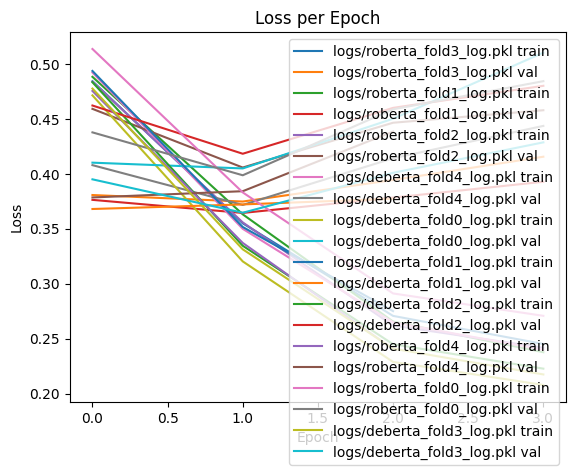

preds/deberta_fold2_probs.npy ROC-AUC: 0.5444


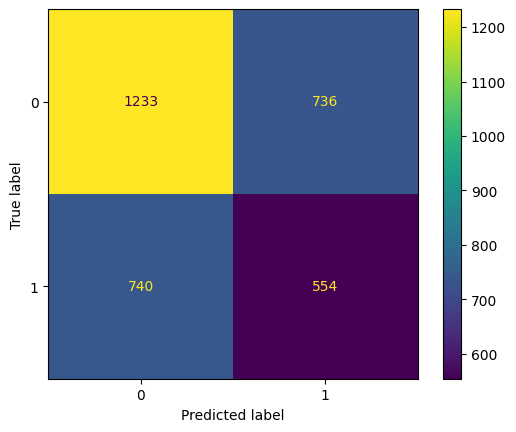

preds/roberta_fold3_probs.npy ROC-AUC: 0.5327


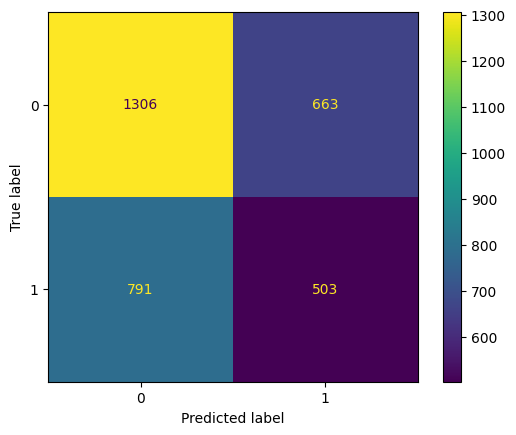

preds/deberta_fold1_probs.npy ROC-AUC: 0.5326


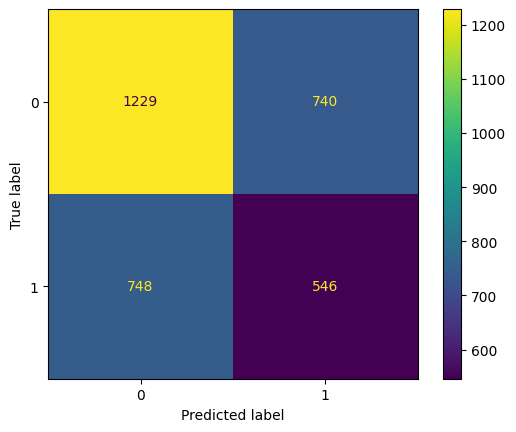

preds/roberta_fold4_probs.npy ROC-AUC: 0.5417


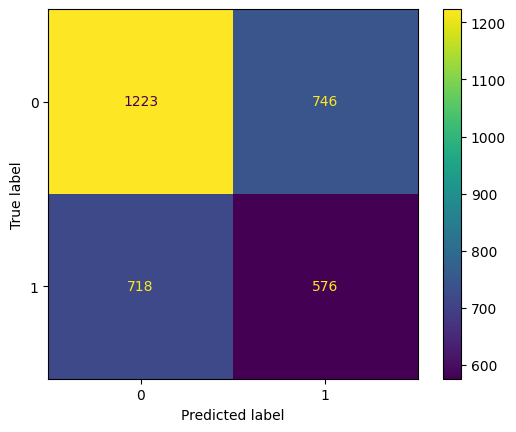

preds/deberta_fold0_probs.npy ROC-AUC: 0.5411


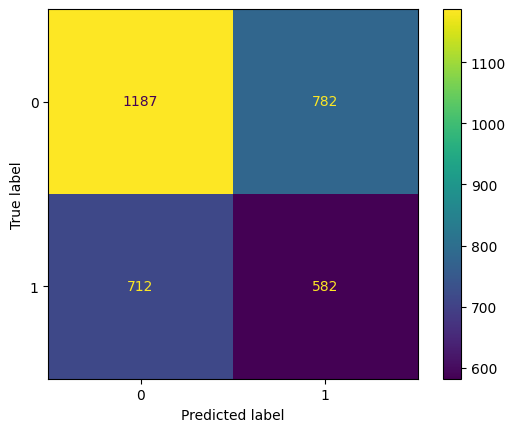

preds/roberta_fold1_probs.npy ROC-AUC: 0.5397


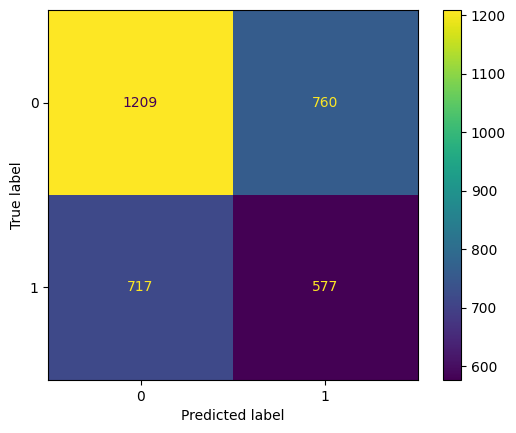

preds/deberta_fold4_probs.npy ROC-AUC: 0.5393


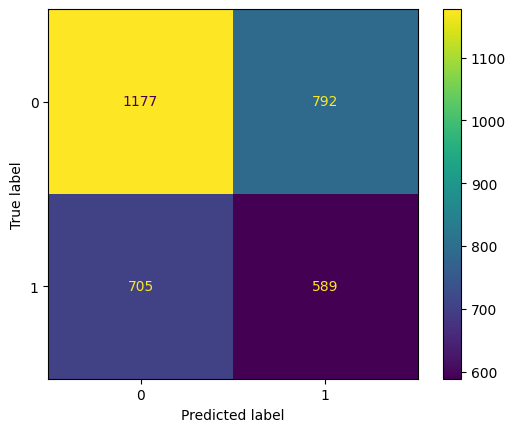

preds/roberta_fold0_probs.npy ROC-AUC: 0.5404


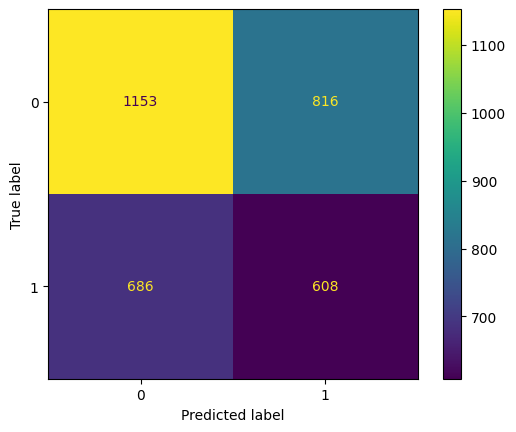

preds/roberta_fold2_probs.npy ROC-AUC: 0.5416


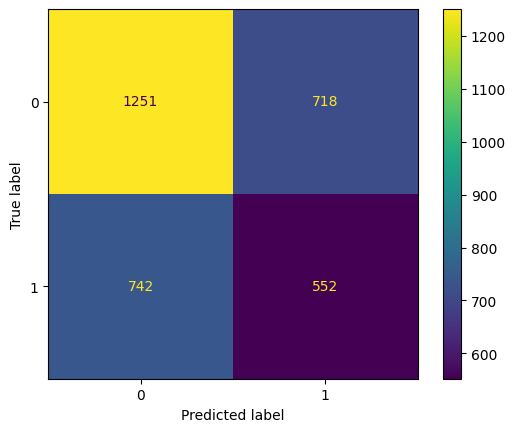

preds/deberta_fold3_probs.npy ROC-AUC: 0.5370


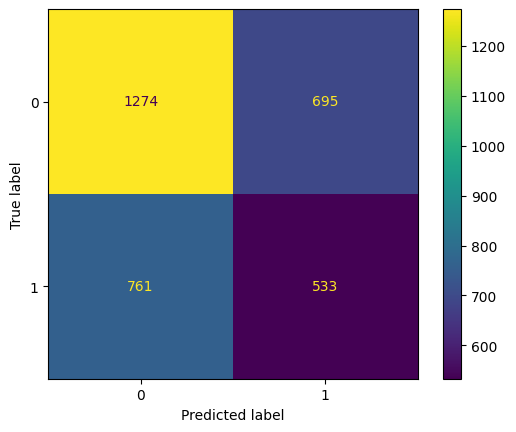

In [ ]:
# plot.py
import pickle
import glob
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Plot Loss & F1
for log_file in glob.glob("logs/*.pkl"):
    with open(log_file, "rb") as f:
        log = pickle.load(f)
    plt.plot(log['train_loss'], label=f"{log_file} train")
    plt.plot(log['val_loss'], label=f"{log_file} val")
plt.legend()
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# ROC-AUC & Confusion Matrix (示範)
probs_files = glob.glob("preds/*_probs.npy")
for f in probs_files:
    probs = np.load(f)
    y_pred = np.argmax(probs, axis=1)
    y_true = pd.read_csv("/content/drive/MyDrive/深度學習/data/train.csv")['target'].values  # 假設全部同標籤（真實情況應該要有 validation label）
    auc = roc_auc_score(y_true[:len(y_pred)], probs[:, 1])
    print(f"{f} ROC-AUC: {auc:.4f}")

    cm = confusion_matrix(y_true[:len(y_pred)], y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()
